In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
%matplotlib inline
plt.style.use('ggplot')

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import mean_squared_error


In [101]:
from importlib import reload
import project_utils
reload(project_utils)

<module 'project_utils' from '/home/ubuntu/Logging_Random_Forests/project_utils.py'>

In [109]:
#Plotting Functions

def plot_results(results_list,n_trees, xlims, ylims, relative = True,titles = None,saveas = None):
    """Plots the results from results_list in 3 different columns if ylims are the same it uses auto y limits"""
    fig, axs = plt.subplots(ncols=len(results_list), nrows = 4, figsize = (10*len(results_list),30))
    
    #plots the difference in error between each forest as you add trees from 1 to n_trees and the full n_trees tree model
    #both randomly and in order of oob score
    
    #this loops over sets of results to compare across hyperparameters
    for i,results in enumerate(results_list):
        #loops across models with different train test splits
        totals = []
        for total, scores, random_scores in results:
            
            totals.append(total)
            if not relative:
                total = 0
            axs[0][i].plot([x for x in range(1,n_trees+ 1)], [s - total  for s in scores], 'b', alpha = 0.1)
            axs[1][i].plot([x for x in range(1,n_trees+ 1)], [s - total  for s in random_scores], 'r', alpha = 0.1)
            axs[2][i].plot([x for x in range(1,n_trees+1)], [s-r for s,r in zip(scores,random_scores)],'m',alpha = 0.1)
            
            if relative: 
                axs[0][i].hlines(0,0,1000,color = 'g',alpha = .8)
                axs[1][i].hlines(0,0,1000,color = 'g',alpha = .8)
                axs[2][i].hlines(0,0,1000,color = 'g',alpha = .8)
        print("mean total error column {}: {}".format(i,np.mean(totals)))

    #plots the average difference between the forests with x trees and the full 1000 tree model
        average_ordered, average_random, average_diff = [],[],[]   
        for x in range(0,n_trees):
            ordered,rand,diff = [],[],[]
            for total,o_scores,r_scores in results:
                if not relative: 
                    total = 0
                ordered.append(o_scores[x] - total)
                rand.append(r_scores[x] - total)
                diff.append(o_scores[x] - r_scores[x])
            average_diff.append(np.mean(diff))
            average_ordered.append(np.mean(ordered))
            average_random.append(np.mean(rand))
        axs[0][i].plot([x for x in range(1,n_trees+ 1)],average_ordered,'b',alpha = .8)        
        axs[1][i].plot([x for x in range(1,n_trees+ 1)],average_random, 'r', alpha = 0.8)
        axs[2][i].plot([x for x in range(1,n_trees+ 1)],average_diff, 'm', alpha = 0.8)
        
        axs[3][i].plot([x for x in range(1,n_trees+ 1)],average_ordered,'b',alpha = .8)                
        axs[3][i].plot([x for x in range(1,n_trees+ 1)],average_random, 'r', alpha = 0.8)
        total_average = 0
        if not relative: 
            total_average = np.mean([r[0] for r in results])
            ylims = ylims[0]+total_average, ylims[1]+total_average
        axs[3][i].hlines(total_average,0,n_trees,color = 'g',alpha = .8)

        #sets the axis limits
        if ylims[0] != ylims[1]:
            axs[0][i].set_ylim(ylims[0],ylims[1])
            axs[1][i].set_ylim(ylims[0],ylims[1])    
            axs[3][i].set_ylim(ylims[0],ylims[1])   
        if titles:
            axs[0][i].set_title(titles[i])
        axs[0][i].set_xlim(xlims[0],xlims[1])
        axs[1][i].set_xlim(xlims[0],xlims[1])
        axs[2][i].set_xlim(xlims[0],xlims[1])
        axs[3][i].set_xlim(xlims[0],xlims[1])
    if saveas:
        plt.savefig(saveas)

    return axs

def plot_average_results(results_list,n_trees, xlims,ylims,titles_list ,saveas = None):
    fig, axs = plt.subplots(ncols=len(results_list[0]), nrows = len(results_list), figsize = (10*len(results_list[0]),10*len(results_list)))
    for i,results in enumerate(results_list):    
        for j,result in enumerate(results):   
            average_ordered, average_random, average_diff,totals = [],[],[],[]   
            for x in range(0,n_trees):
                ordered,rand,diff = [],[],[]
                for total,o_scores,r_scores in result:
                    totals.append(total)
                    ordered.append(o_scores[x] - total)
                    rand.append(r_scores[x] - total)
                    diff.append(o_scores[x] - r_scores[x])
                average_diff.append(np.mean(diff))
                average_ordered.append(np.mean(ordered))
                average_random.append(np.mean(rand))      
            total_average = np.mean(totals)
            axs[i][j].plot([x for x in range(1,n_trees+ 1)],average_ordered,'b',alpha = .8)                
            axs[i][j].plot([x for x in range(1,n_trees+ 1)],average_random, 'r', alpha = 0.8)
            axs[i][j].hlines(0,0,1000,color = 'g',alpha = .8)   
            working_title = titles_list[i][j]+" average error (green): {}".format(str(round(total_average,3)))
            axs[i][j].set_title(working_title)
            axs[i][j].set_ylim(ylims[0],ylims[1])   
            axs[i][j].set_xlim(xlims[0],xlims[1])
    if saveas:
        plt.savefig(saveas)
        
    return axs

In [92]:
def run_parameter_experiment(X,y,params,manipulated_vars,changes):
    full_results,full_titles = [],[]
    for pairs in changes:
        results = []
        titles = []
        for c in pairs:
            params[manipulated_vars[0]], params[manipulated_vars[1]] = c[0],c[1]
            results.append(project_utils.run_experiment(X,y,5,10,params))
            titles.append('{}: {}, {}: {}'.format(manipulated_vars[0],c[0],manipulated_vars[1],c[1]))
        full_results.append(results)
        full_titles.append(titles)
        
    return full_results,full_titles


In [5]:
data = pd.read_csv('data/OnlineNewsPopularity.csv')

In [6]:
y = data[' shares'].values
X = data.drop([' shares','url',' timedelta'], axis = 1).values

In [4]:
parameters = {
    'n_estimators':[1000],
    'max_features':['sqrt',None], 'max_depth':[2,3,4,5],
    'min_samples_split':[.1,.5],'min_samples_leaf':[1,2,5],
    'bootstrap':[True]
}

rfr = RandomForestRegressor()
grid_search1 = GridSearchCV(rfr, param_grid=parameters, 
                            scoring = 'neg_mean_squared_error',
                            n_jobs = -1, cv = 10, verbose = 1)
grid_search1.fit(X,y)

Fitting 10 folds for each of 72 candidates, totalling 720 fits
[CV] max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=0.1, n_estimators=1000 
[CV] max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=0.1, n_estimators=1000 
[CV] max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=0.1, n_estimators=1000 
[CV] max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=0.1, n_estimators=1000 
[CV] max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=0.1, n_estimators=1000 
[CV] max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=0.1, n_estimators=1000 
[CV] max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=0.1, n_estimators=1000 
[CV] max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=0.1, n_estimators=1000 
[CV] max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=0.1, n_estimators=1000 
[CV] max_depth=2, max_features=sqrt, min_sampl

KeyboardInterrupt: 

In [105]:
params = grid_search1.best_params_
changes= [[(None,2),(None,3),(None,4),(None,5)] , [('sqrt',2),('sqrt',3),('sqrt',4),('sqrt',5)]]
params['bootstrap'] = True

In [106]:
results1, titles1 = run_parameter_experiment(X,y,params,['max_features','max_depth'],changes)

10/50 done in 13.566 seconds
50 models done in 1.142 minutes
10/50 done in 13.854 seconds
50 models done in 1.149 minutes
10/50 done in 14.745 seconds
50 models done in 1.231 minutes
10/50 done in 14.573 seconds
50 models done in 1.227 minutes
10/50 done in 13.754 seconds
50 models done in 1.142 minutes
10/50 done in 13.996 seconds
50 models done in 1.144 minutes
10/50 done in 14.935 seconds
50 models done in 1.229 minutes
10/50 done in 15.019 seconds
50 models done in 1.235 minutes


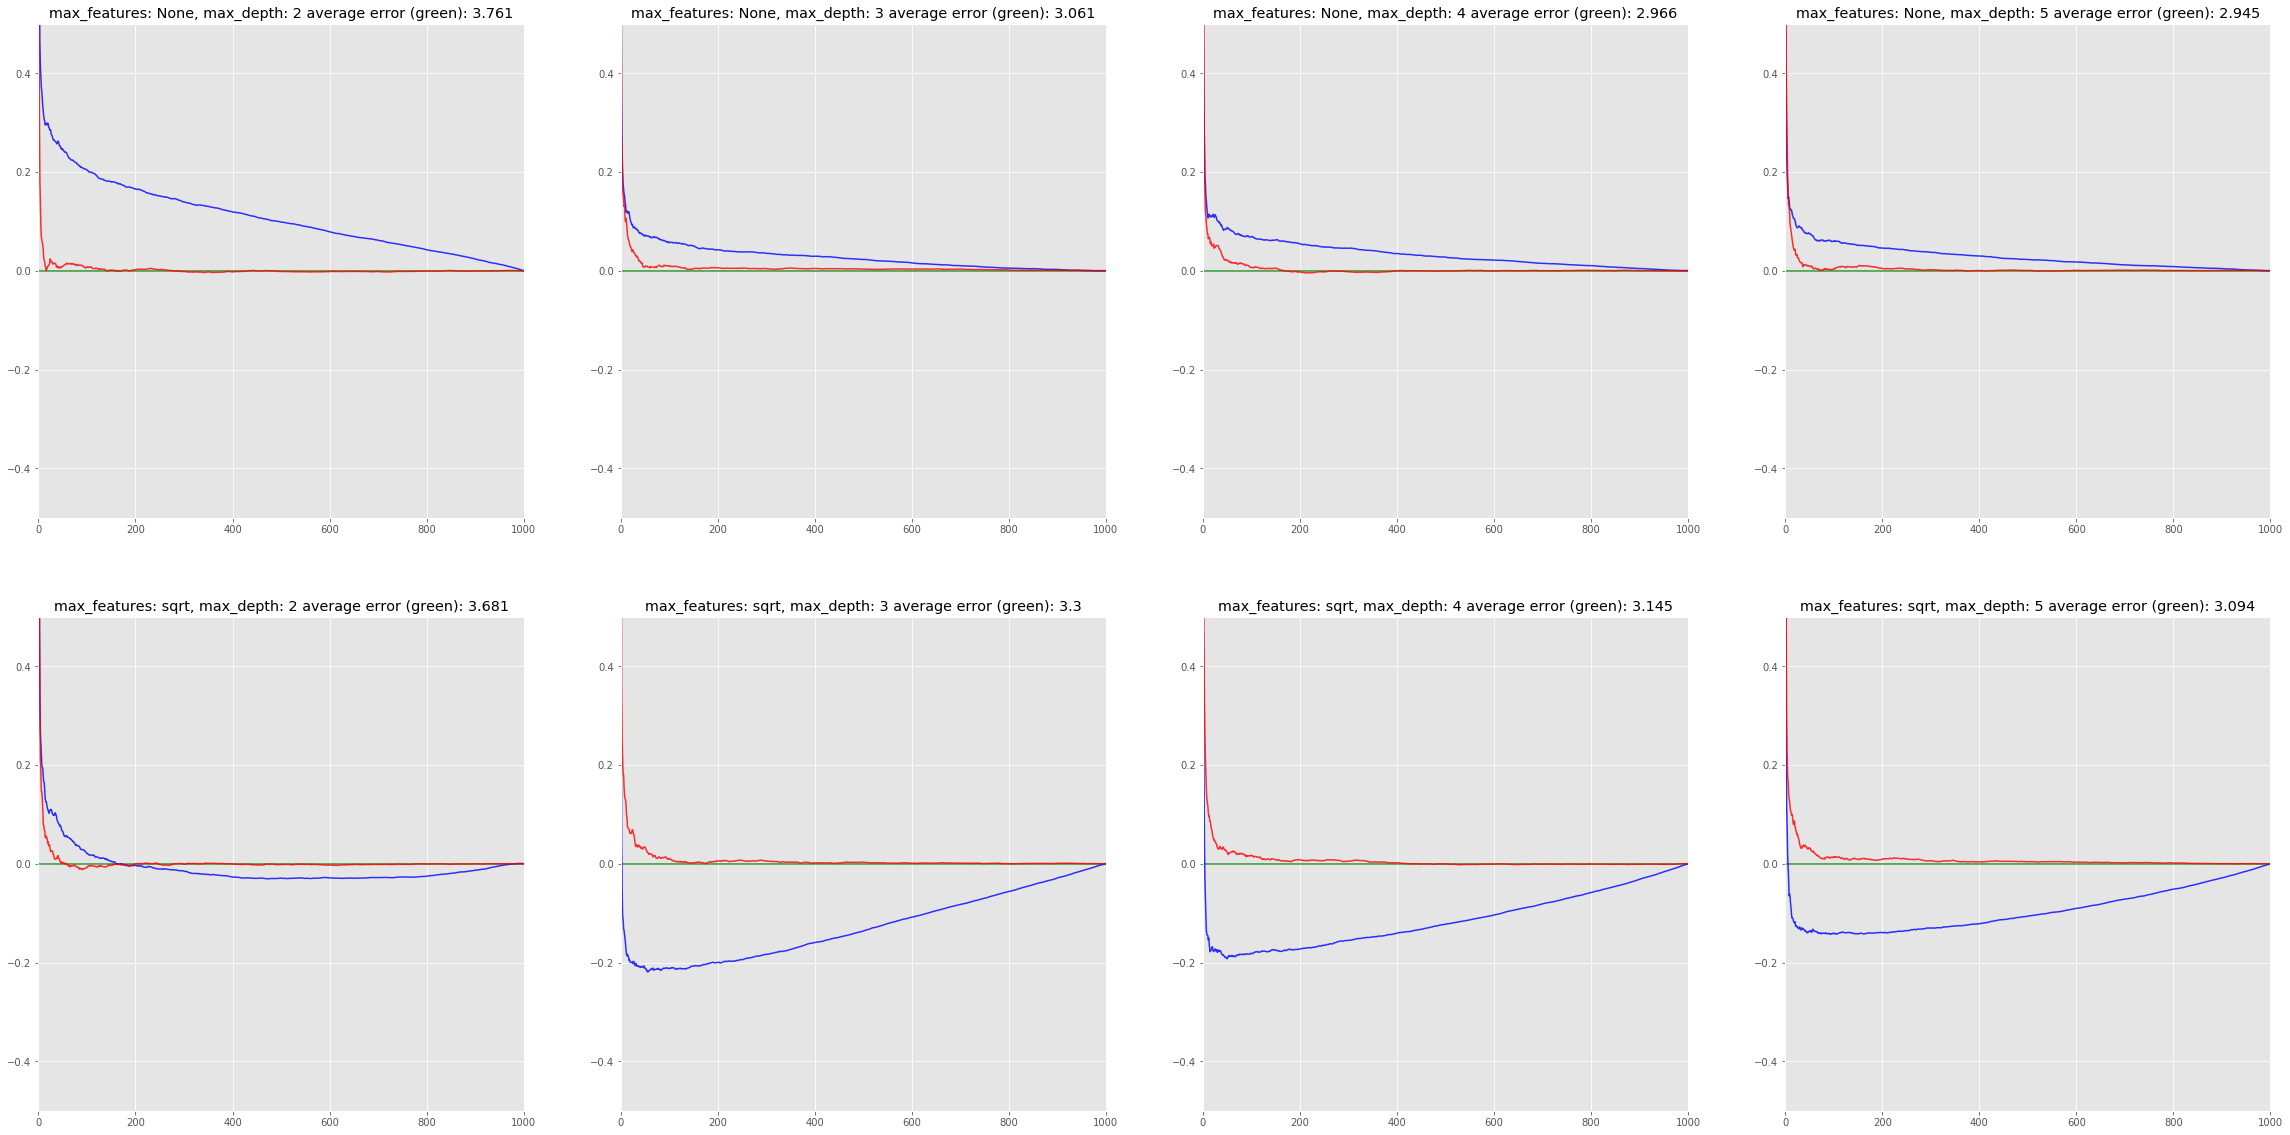

In [107]:
axs1 = plot_average_results(results1,1000,(0,1000),(-.5, .5),titles1,'plots/online_news.jpg')

10/50 done in 98.60203456878662 seconds
10/50 done in 104.631991147995 seconds
10/50 done in 112.45882797241211 seconds
10/50 done in 118.70811223983765 seconds
10/50 done in 197.18554592132568 seconds


In [6]:
data2 = pd.read_csv('data/slump_test.data.csv',index_col='No')

In [7]:
X2,y2 = data2.drop('Compressive Strength (28-day)(Mpa)', axis = 1).values,data2['Compressive Strength (28-day)(Mpa)'].values

In [278]:

rfr = RandomForestRegressor()
grid_search2 = GridSearchCV(rfr, param_grid=parameters, 
                            scoring = 'neg_mean_squared_error',
                            n_jobs = -1, cv = 10, verbose = 1)
grid_search2.fit(X2,y2)

Fitting 10 folds for each of 72 candidates, totalling 720 fits
[CV] max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=0.1, n_estimators=1000 
[CV] max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=0.1, n_estimators=1000 
[CV] max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=0.1, n_estimators=1000 
[CV] max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=0.1, n_estimators=1000 
[CV]  max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=0.1, n_estimators=1000, total=   1.3s
[CV] max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=0.1, n_estimators=1000 
[CV]  max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=0.1, n_estimators=1000, total=   1.4s
[CV] max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=0.1, n_estimators=1000 
[CV]  max_depth=2, max_features=sqrt, min_samples_leaf=1, min_samples_split=0.1, n_estimators=1000, total=   1.7s
[

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   15.6s


[CV]  max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=0.5, n_estimators=1000, total=   1.7s
[CV] max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=0.5, n_estimators=1000 
[CV]  max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=0.5, n_estimators=1000, total=   1.7s
[CV] max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=0.5, n_estimators=1000 
[CV]  max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=0.5, n_estimators=1000, total=   1.8s
[CV] max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=0.5, n_estimators=1000 
[CV]  max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=0.5, n_estimators=1000, total=   1.8s
[CV] max_depth=2, max_features=sqrt, min_samples_leaf=5, min_samples_split=0.1, n_estimators=1000 
[CV]  max_depth=2, max_features=sqrt, min_samples_leaf=2, min_samples_split=0.5, n_estimators=1000, total=   1.6s
[CV] max_depth=2, max_features=sqr

[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.1min


[CV]  max_depth=2, max_features=None, min_samples_leaf=2, min_samples_split=0.5, n_estimators=1000, total=   1.5s
[CV] max_depth=2, max_features=None, min_samples_leaf=2, min_samples_split=0.5, n_estimators=1000 
[CV]  max_depth=2, max_features=None, min_samples_leaf=2, min_samples_split=0.5, n_estimators=1000, total=   1.4s
[CV] max_depth=2, max_features=None, min_samples_leaf=2, min_samples_split=0.5, n_estimators=1000 
[CV]  max_depth=2, max_features=None, min_samples_leaf=2, min_samples_split=0.5, n_estimators=1000, total=   1.5s
[CV] max_depth=2, max_features=None, min_samples_leaf=5, min_samples_split=0.1, n_estimators=1000 
[CV]  max_depth=2, max_features=None, min_samples_leaf=2, min_samples_split=0.5, n_estimators=1000, total=   1.5s
[CV] max_depth=2, max_features=None, min_samples_leaf=5, min_samples_split=0.1, n_estimators=1000 
[CV]  max_depth=2, max_features=None, min_samples_leaf=2, min_samples_split=0.5, n_estimators=1000, total=   1.5s
[CV] max_depth=2, max_features=Non

[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  2.5min


[CV]  max_depth=3, max_features=None, min_samples_leaf=5, min_samples_split=0.5, n_estimators=1000, total=   1.7s
[CV] max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=0.1, n_estimators=1000 
[CV]  max_depth=3, max_features=None, min_samples_leaf=5, min_samples_split=0.5, n_estimators=1000, total=   1.4s
[CV] max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=0.1, n_estimators=1000 
[CV]  max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=0.1, n_estimators=1000, total=   1.5s
[CV] max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=0.1, n_estimators=1000 
[CV]  max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=0.1, n_estimators=1000, total=   1.6s
[CV] max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=0.1, n_estimators=1000 
[CV]  max_depth=4, max_features=sqrt, min_samples_leaf=1, min_samples_split=0.1, n_estimators=1000, total=   1.7s
[CV] max_depth=4, max_features=sqr

[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  4.7min


[CV]  max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=0.1, n_estimators=1000, total=   1.4s
[CV] max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=0.1, n_estimators=1000 
[CV]  max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=0.1, n_estimators=1000, total=   1.5s
[CV] max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=0.1, n_estimators=1000 
[CV]  max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=0.1, n_estimators=1000, total=   1.4s
[CV] max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=0.1, n_estimators=1000 
[CV]  max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=0.1, n_estimators=1000, total=   1.4s
[CV] max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=0.1, n_estimators=1000 
[CV]  max_depth=5, max_features=log2, min_samples_leaf=5, min_samples_split=0.1, n_estimators=1000, total=   1.5s
[CV] max_depth=5, max_features=log

[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:  5.2min finished


GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [1000], 'max_features': ['sqrt', 'log2', None], 'max_depth': [2, 3, 4, 5], 'min_samples_split': [0.1, 0.5], 'min_samples_leaf': [1, 2, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=2)

In [30]:
params2 = grid_search2.best_params_


In [31]:
params2a,params2b = params2,params2
params2a['max_features'],params2b['max_features'] = 'sqrt',None
results2  = [run_experiment(X2,y2,10,10,params2b),run_experiment(X2,y2,10,10,params2a)]

10/100 done in 14.392448663711548 seconds
60/100 done in 86.19223928451538 seconds
10/100 done in 14.284542322158813 seconds
60/100 done in 85.44421935081482 seconds


In [26]:
changes= [[(None,2),(None,3),(None,4),(None,5)] , [('sqrt',2),('sqrt',3),('sqrt',4),('sqrt',5)]]


In [24]:
results, titles = run_parameter_experiment(X2,y2,params2,['max_features','max_depth'],[changesa,changesb])

10/50 done in 13.827059507369995 seconds
10/50 done in 13.3377046585083 seconds
10/50 done in 13.379757165908813 seconds
10/50 done in 14.54031229019165 seconds
10/50 done in 13.354266881942749 seconds
10/50 done in 13.259222507476807 seconds
10/50 done in 14.200525760650635 seconds
10/50 done in 14.339911937713623 seconds


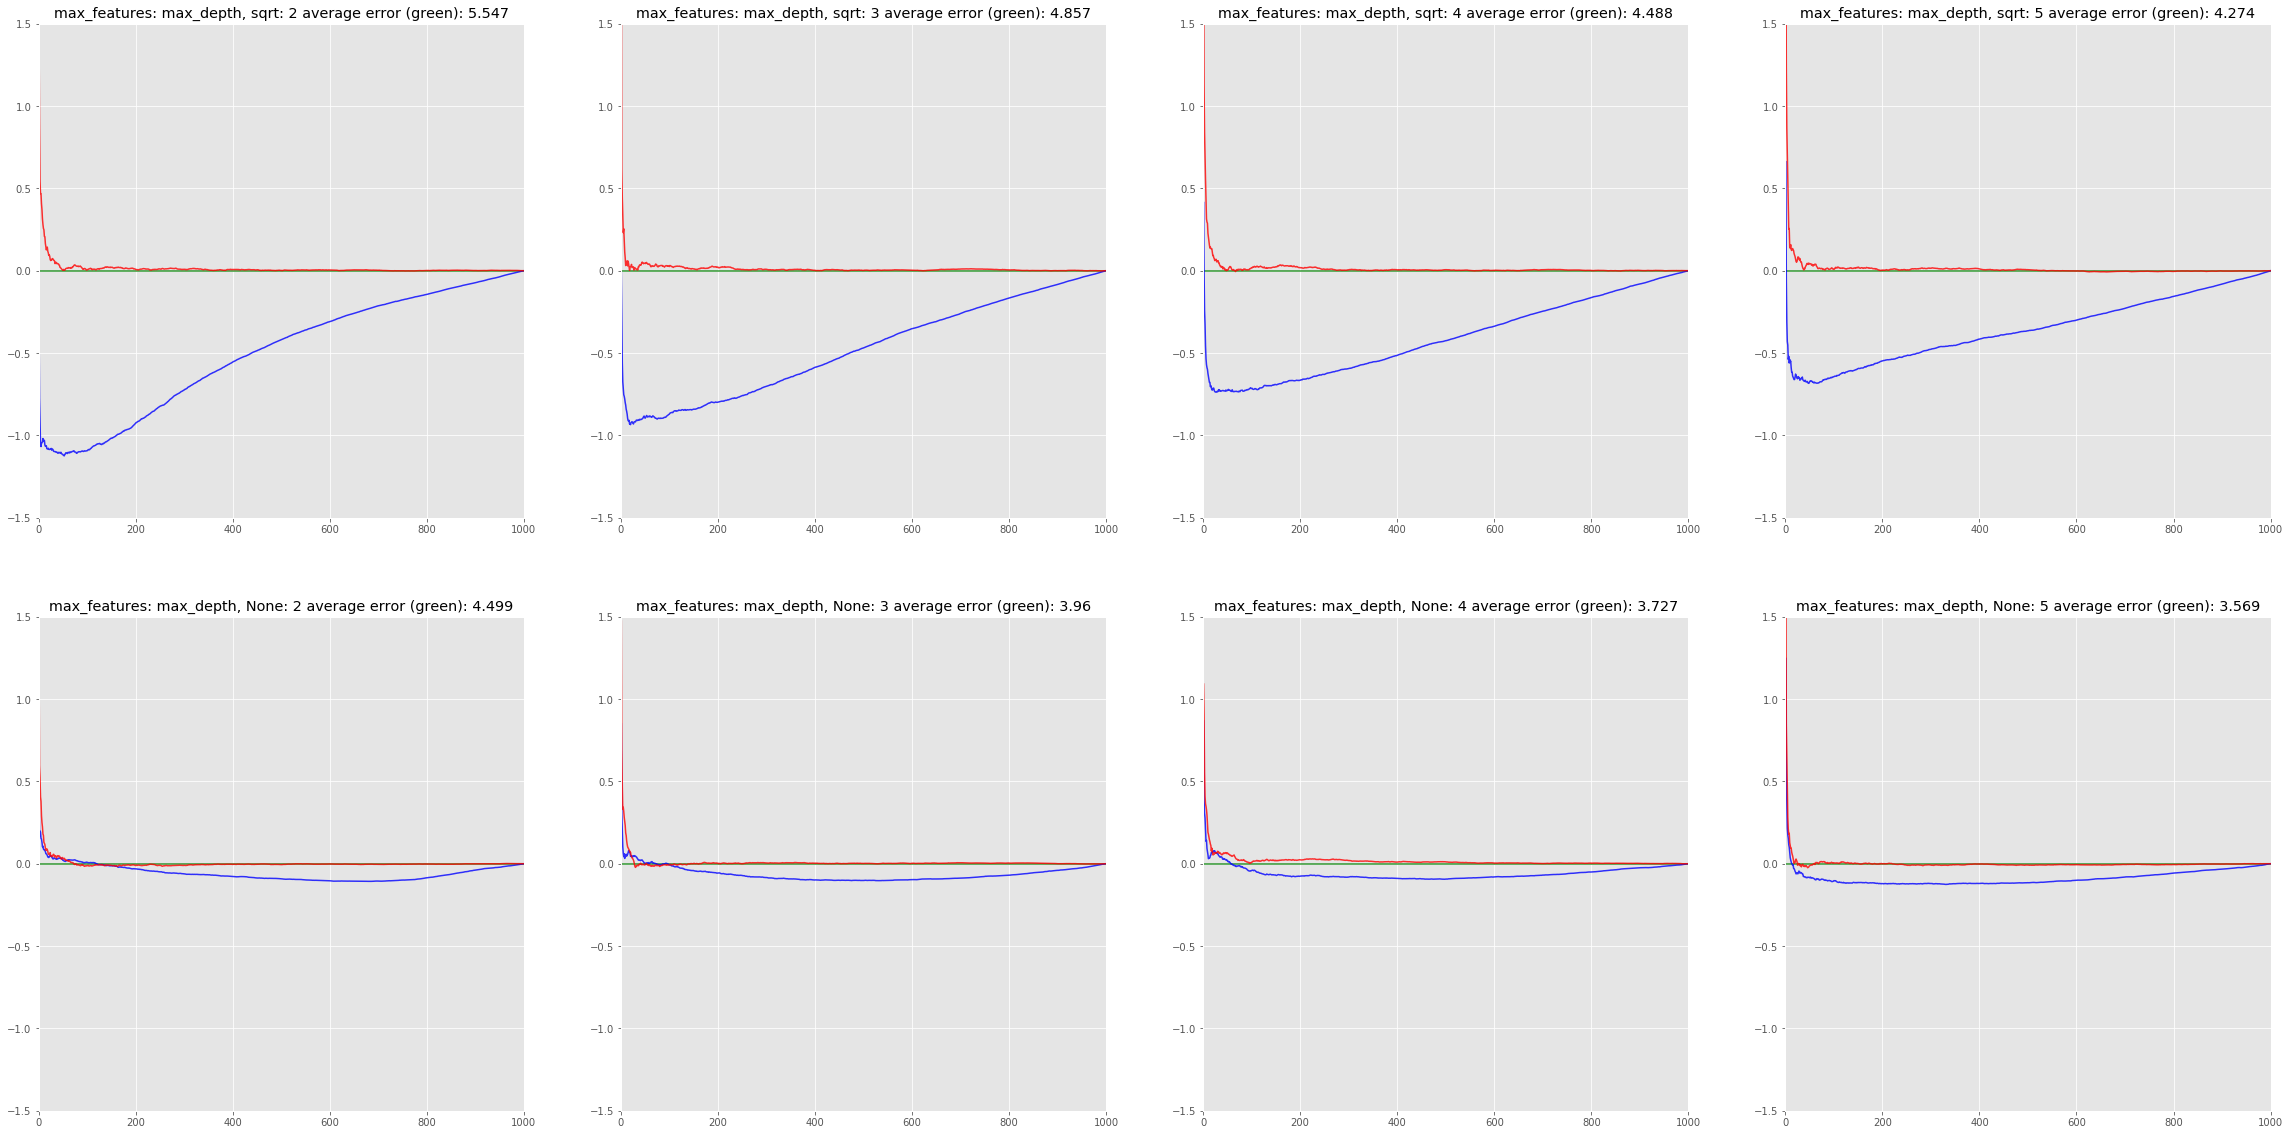

In [25]:
axs2 = plot_average_results(results,1000,(0,1000),(-1.5,1.5),titles,'concretecompression.jpg')

In [27]:
# this data has only categorical variables so we can see that effect
data3 = pd.read_csv('data/flare.data2.csv',header=None, delimiter = ' ')

In [28]:
data3.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,H,A,X,1,3,1,1,1,1,1,0,0,0
1,D,R,O,1,3,1,1,2,1,1,0,0,0
2,C,S,O,1,3,1,1,2,1,1,0,0,0


In [29]:
X3 = pd.get_dummies(data3,columns=[0,1,2,3,4,5,6,7,8,9]).drop([10,11,12], axis = 1).values
y3 = data3[10].values

In [38]:
parameters = {
    'n_estimators':[1000],
    'max_features':['sqrt','log2',None], 'max_depth':[2,3,4,5],
    'min_samples_split':[.1,.5],'min_samples_leaf':[1,2,5],
}

rfr = RandomForestRegressor()
grid_search3 = GridSearchCV(rfr, param_grid=parameters, 
                            scoring = 'neg_mean_squared_error',
                            n_jobs = -1, cv = 10, verbose = 1)
grid_search3.fit(X3,y3)

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   43.4s
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:  1.3min finished


GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [1000], 'max_features': ['sqrt', 'log2', None], 'max_depth': [2, 3, 4, 5], 'min_samples_split': [0.1, 0.5], 'min_samples_leaf': [1, 2, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=1)

In [86]:
params3 = grid_search3.best_params_
params3

{'max_depth': 4,
 'max_features': 'sqrt',
 'min_samples_leaf': 5,
 'min_samples_split': 0.1,
 'n_estimators': 1000}

In [31]:
params3 = {'max_depth': 4,
 'max_features': 'sqrt',
 'min_samples_leaf': 5,
 'min_samples_split': 0.1,
 'n_estimators': 1000}

changes= [[(None,2),(None,3),(None,4),(None,5)] , [('sqrt',2),('sqrt',3),('sqrt',4),('sqrt',5)]]



In [32]:
results3, titles3 = run_parameter_experiment(X3,y3,params3,['max_features','max_depth'],changes)

10/50 done in 14.481840372085571 seconds
10/50 done in 14.488104343414307 seconds
10/50 done in 15.482144355773926 seconds
10/50 done in 15.62155270576477 seconds
10/50 done in 14.219292402267456 seconds
10/50 done in 14.322336196899414 seconds
10/50 done in 15.371674299240112 seconds
10/50 done in 15.550163984298706 seconds


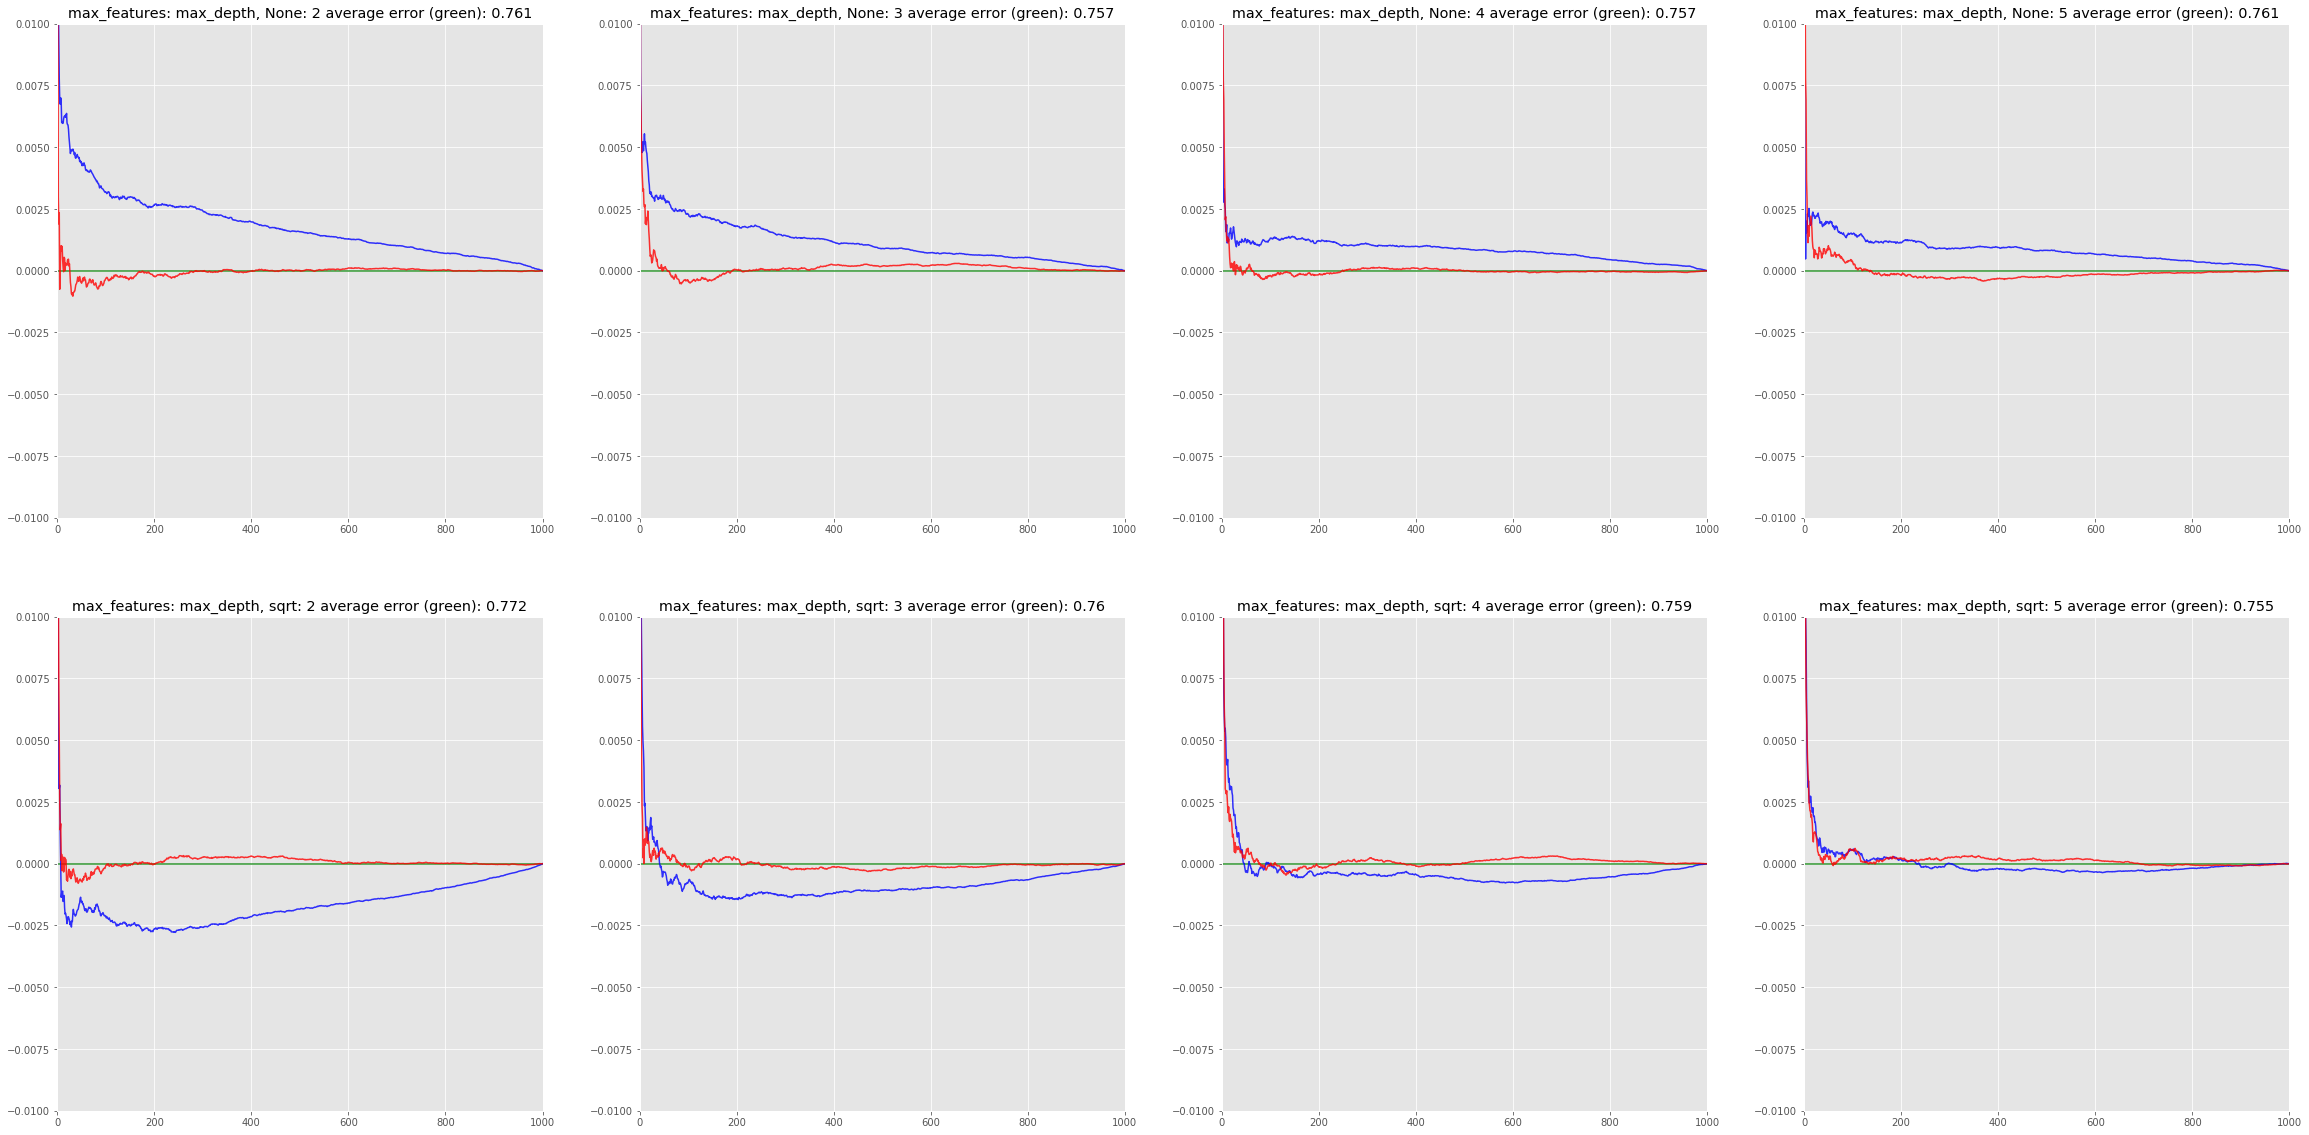

In [33]:
axs3 = plot_average_results(results3,1000,(0,1000),(-.01,.01),titles3,'flare_data.jpg')

In [34]:
data4 = pd.read_csv("data/student-mat.csv",delimiter = ";")

In [35]:
X4 = pd.get_dummies(data4,columns = ['school','sex','address','famsize','Pstatus','Medu',
                    'Fedu','Mjob','Fjob','reason','guardian','traveltime',
                    'studytime','failures','schoolsup','famsup','paid','activities',
                    'activities','nursery','higher','internet','romantic']).drop(['G1','G2','G3'],axis = 1).values
y4 = data4['G3'].values

In [36]:
parameters = {
    'n_estimators':[1000],
    'max_features':['sqrt',None], 'max_depth':[2,3,4,5],
    'min_samples_split':[.1,.5,.8],'min_samples_leaf':[1,2,5],
}

rfr = RandomForestRegressor()
grid_search4 = GridSearchCV(rfr, param_grid=parameters, 
                            scoring = 'neg_mean_squared_error',
                            n_jobs = -1, cv = 10, verbose = 1)
grid_search4.fit(X4,y4)

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   42.4s
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:  1.2min finished


GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [1000], 'max_features': ['sqrt', None], 'max_depth': [2, 3, 4, 5], 'min_samples_split': [0.1, 0.5, 0.8], 'min_samples_leaf': [1, 2, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=1)

In [38]:
params = grid_search4.best_params_
params

{'max_depth': 5,
 'max_features': None,
 'min_samples_leaf': 2,
 'min_samples_split': 0.1,
 'n_estimators': 1000}

In [44]:
params4 = {'max_depth': 5,
 'max_features': None,
 'min_samples_leaf': 2,
 'min_samples_split': 0.1,
 'n_estimators': 1000}

changes= [[(None,2),(None,3),(None,4),(None,5)] , [('sqrt',2),('sqrt',3),('sqrt',4),('sqrt',5)]]


In [45]:
results4, titles4 = run_parameter_experiment(X4,y4,params4,['max_features','max_depth'],changes)

10/50 done in 13.946 seconds
50 models done in 1.161 minutes
10/50 done in 13.905 seconds
50 models done in 1.168 minutes
10/50 done in 14.922 seconds
50 models done in 1.246 minutes
10/50 done in 15.164 seconds
50 models done in 1.251 minutes
10/50 done in 13.947 seconds
50 models done in 1.164 minutes
10/50 done in 13.894 seconds
50 models done in 1.16 minutes
10/50 done in 15.058 seconds
50 models done in 1.251 minutes
10/50 done in 14.966 seconds
50 models done in 1.251 minutes


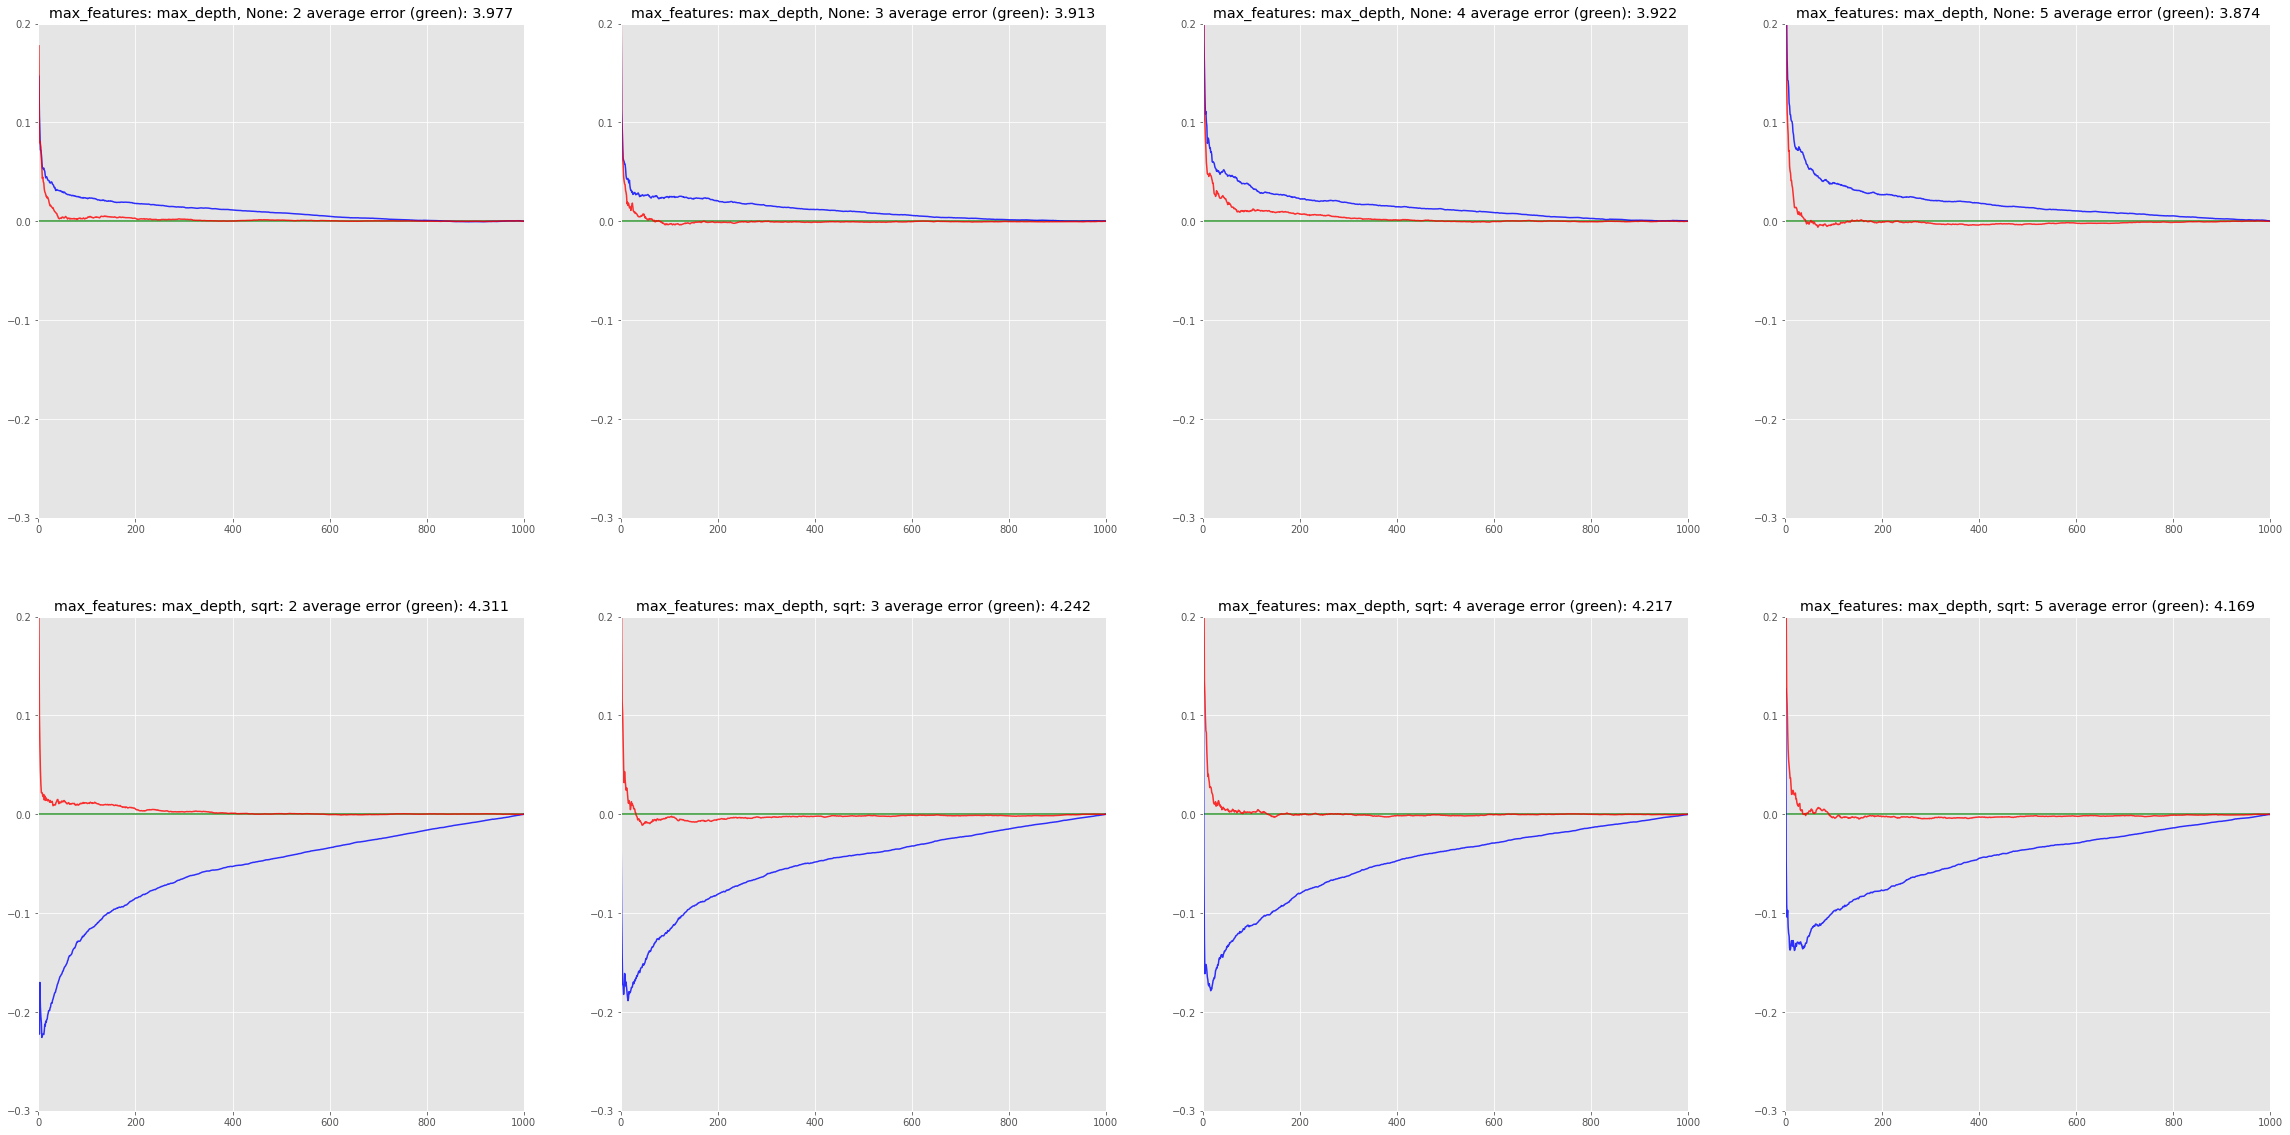

In [51]:
axs4 = plot_average_results(results4,1000,(0,1000),(-.3, .2),titles4,'plots/student_data.jpg')

In [65]:
data5 = pd.read_csv('data/auto-mpg.data.csv',delim_whitespace= True, header=None)

In [71]:
data5.head()

,0,1,2,3,4,5,6,7,8
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino


In [72]:
data5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
0    398 non-null float64
1    398 non-null int64
2    398 non-null float64
3    398 non-null object
4    398 non-null float64
5    398 non-null float64
6    398 non-null int64
7    398 non-null int64
8    398 non-null object
dtypes: float64(4), int64(3), object(2)
memory usage: 28.1+ KB


In [81]:
data5 = data5[data5[3] != '?']

In [82]:
X5 = data5.drop([8,0],axis = 1).values
y5 = data5[0].values

In [83]:
parameters = {
    'n_estimators':[1000],
    'max_features':['sqrt',None], 'max_depth':[2,3,4,5],
    'min_samples_split':[.1,.5,.8],'min_samples_leaf':[1,2,5],
}

rfr = RandomForestRegressor()
grid_search5 = GridSearchCV(rfr, param_grid=parameters, 
                            scoring = 'neg_mean_squared_error',
                            n_jobs = -1, cv = 10, verbose = 1)
grid_search5.fit(X5,y5)

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   40.1s
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:  1.1min finished


GridSearchCV(cv=10, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [1000], 'max_features': ['sqrt', None], 'max_depth': [2, 3, 4, 5], 'min_samples_split': [0.1, 0.5, 0.8], 'min_samples_leaf': [1, 2, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=1)

In [105]:
params5 = grid_search5.best_params_
changes= [[(None,2),(None,3),(None,4),(None,5)] , [('sqrt',2),('sqrt',3),('sqrt',4),('sqrt',5)]]
params5['bootstrap'] = True

In [106]:
results5, titles5 = run_parameter_experiment(X5,y5,params5,['max_features','n_estimators'],changes)

10/50 done in 13.566 seconds
50 models done in 1.142 minutes
10/50 done in 13.854 seconds
50 models done in 1.149 minutes
10/50 done in 14.745 seconds
50 models done in 1.231 minutes
10/50 done in 14.573 seconds
50 models done in 1.227 minutes
10/50 done in 13.754 seconds
50 models done in 1.142 minutes
10/50 done in 13.996 seconds
50 models done in 1.144 minutes
10/50 done in 14.935 seconds
50 models done in 1.229 minutes
10/50 done in 15.019 seconds
50 models done in 1.235 minutes


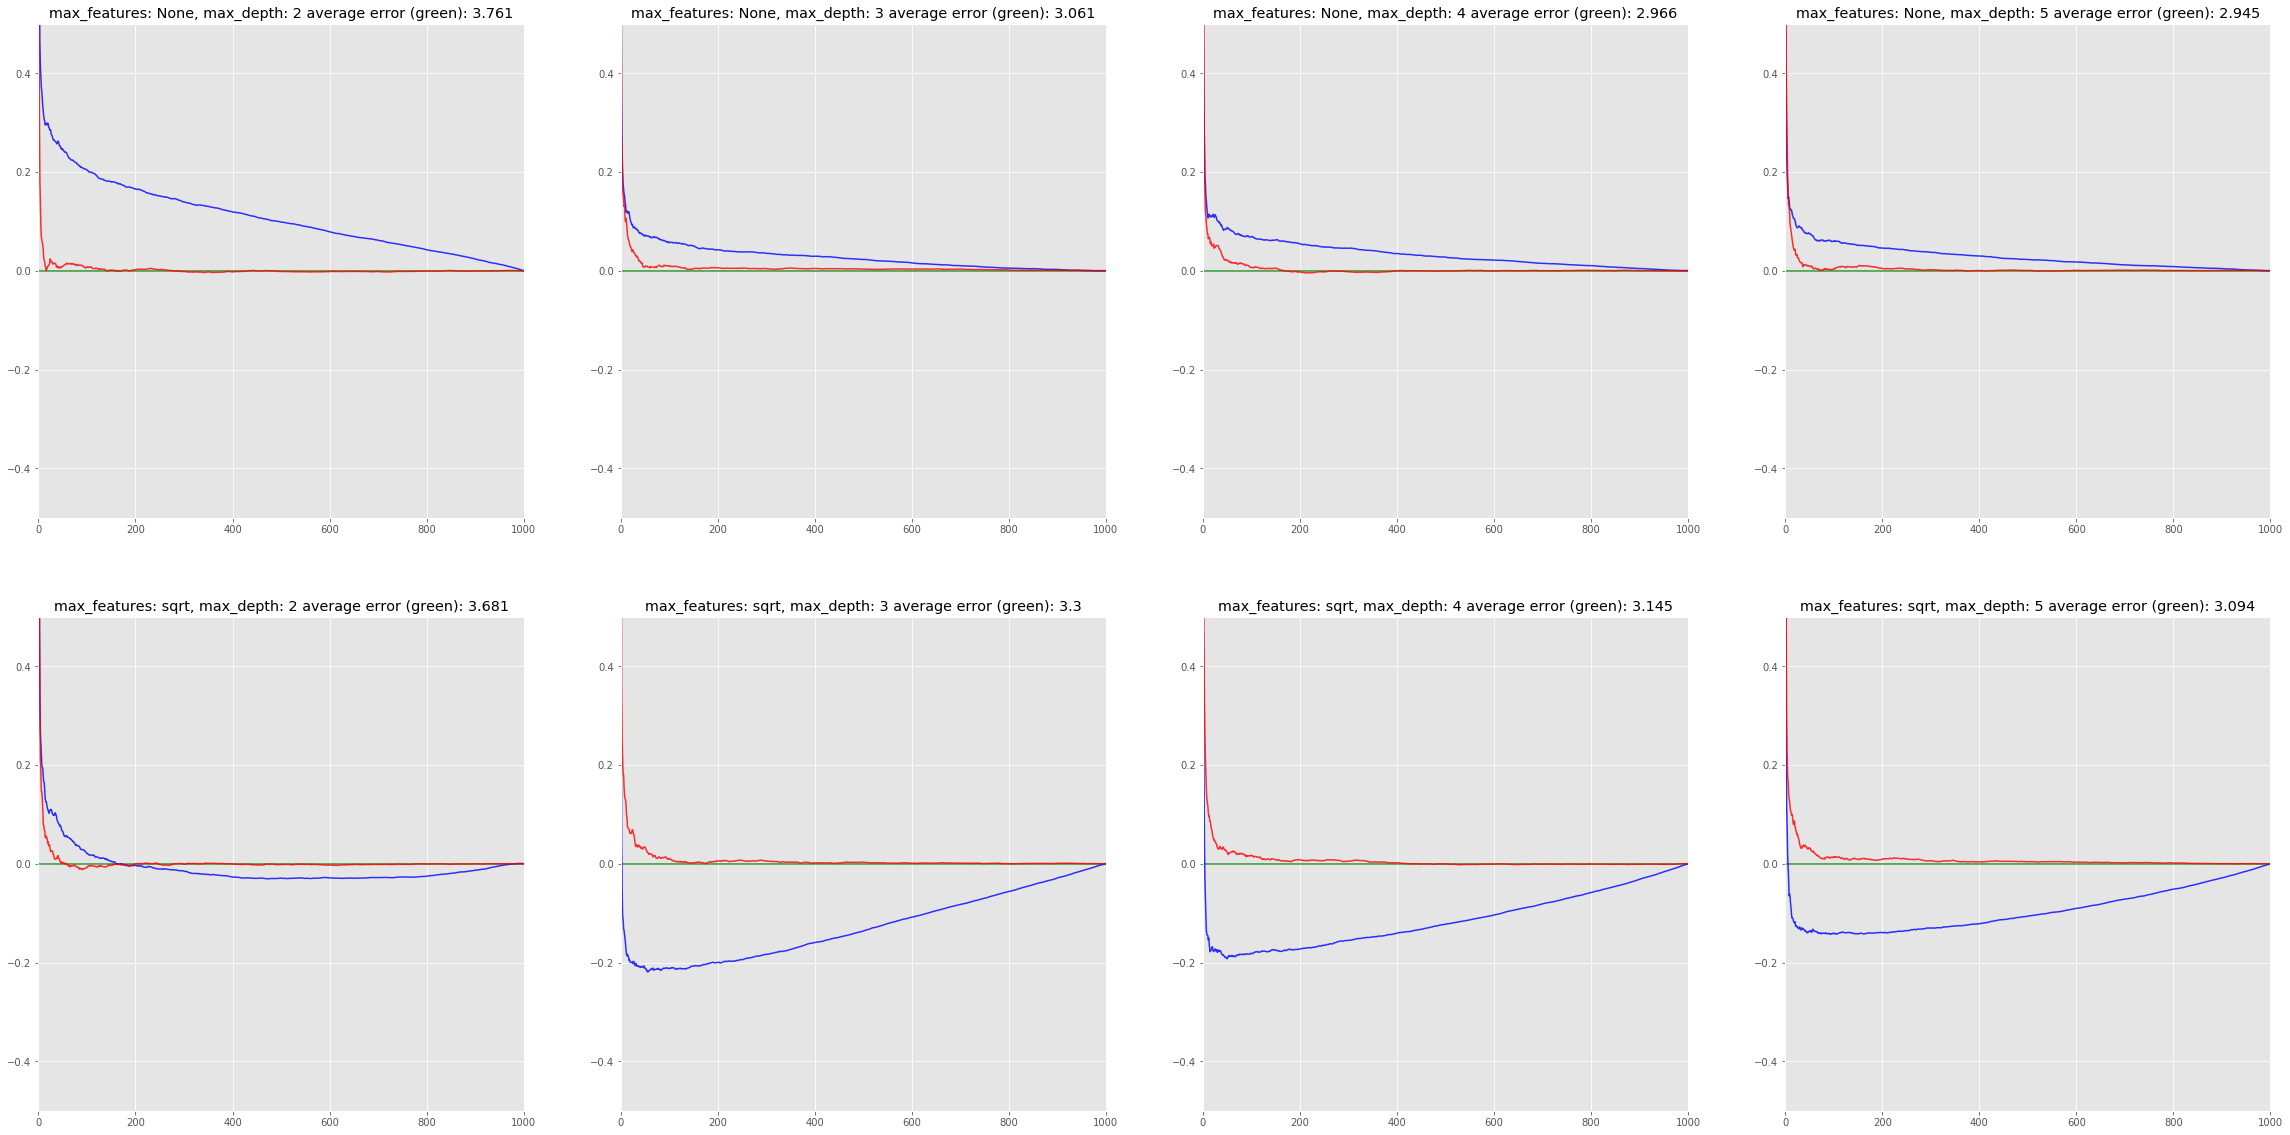

In [107]:
axs5 = plot_average_results(results5,1000,(0,1000),(-.5, .5),titles5,'plots/mpg_data.jpg')

mean total error column 0: 3.76054414180596
mean total error column 1: 3.0610944689432005
mean total error column 2: 2.965796540642119
mean total error column 3: 2.944578738456081


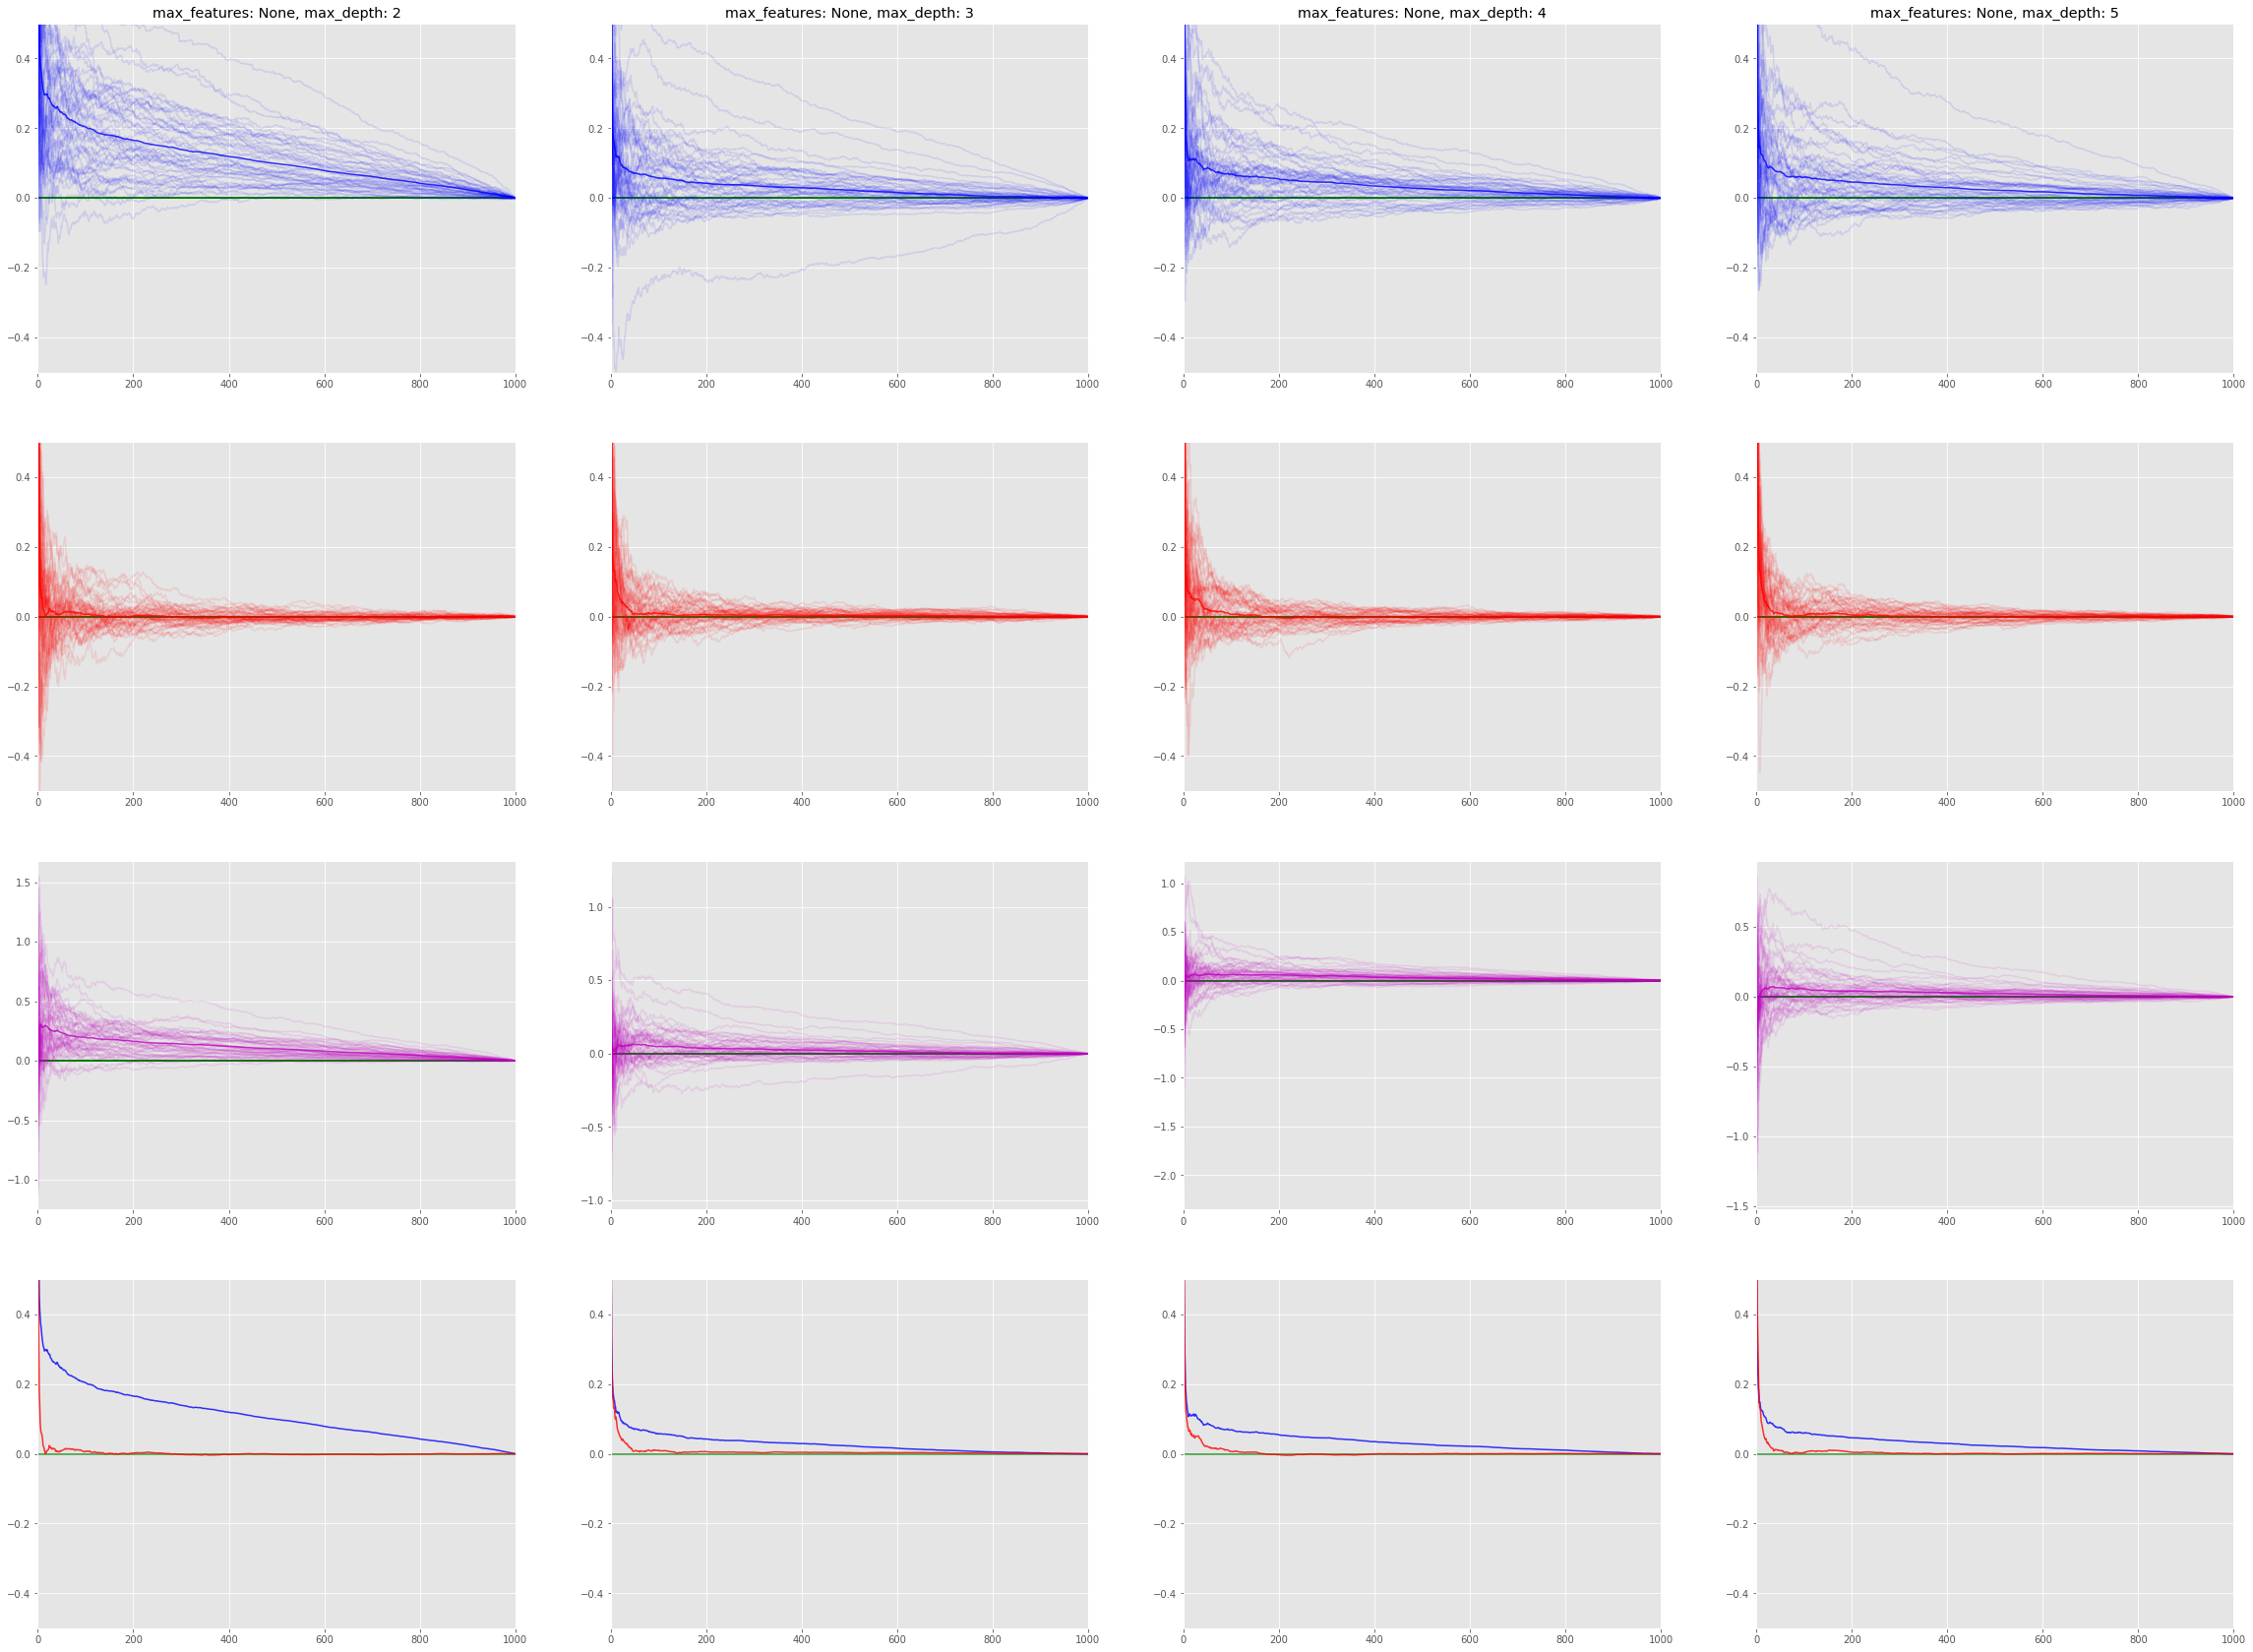

In [108]:
axs5b = plot_results(results5[0],1000,(0,1000),(-.5, .5),titles= titles5[0])